In [1]:
%matplotlib inline 
import sys
sys.path.append("..")


import numpy as np
import random
import csv

from idtrees.utils import read_tifs #, load_data # Import data utils
from idtrees.utils.get_data import *
import matplotlib.pyplot as plt
from configs import *

import pandas as pd
from sklearn.model_selection import train_test_split


### Extracting ITCs as differently sized HSI images with a Tree Species Label

In [2]:
im_all_new, new_class_ids, class_id_val, n_px_val, sci_names, special_val_px = get_data()

Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 749
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 1046
Classes to be used: [23. 26. 22.  2. 30. 18.]
Counts for these classes [ 53.  97. 103. 139. 169. 367.]
Number of trees, labeled with species and bounding box:  1165
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 749
[WARNING] Loaded box has zero shape and is sketchily inflated. TODO: skip this box with ID 1046


In [3]:
spectra = [] # List of spectrum per pixel # TODO write as ndarray
class_id_new = [] # List of target per pixel 

for index in range(len(im_all_new)):
    # Append the spectra and class id of all pixels in bbox to a list
    n_px = np.prod(im_all_new[index].shape[1:])
    spectra.append(im_all_new[index].reshape(-1, n_px))
    class_id_new.append(new_class_ids[index] * np.ones(n_px))

# Convert list into ndarray
spectra = np.concatenate(spectra, axis=1)#.numpy())
class_id_new = np.concatenate(class_id_new, axis=0)

# Add class ids as zero'th row 
pixel_data = np.vstack((class_id_new[np.newaxis,:], spectra))


In [4]:
freq = pd.DataFrame({'class_ids': class_id_val, 'num_pix': n_px_val, 'sci_names': sci_names})
freq.loc[6, :] = ['34.', str(np.sum(special_val_px)), "ALL OTHER"]

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets

In [6]:
# Prepare data
n_train = int(.8 * pixel_data.shape[1])
xy = np.rollaxis(pixel_data, 1) # Format X into (n_samples, n_features)
np.random.shuffle(xy) # Shuffle randomly along axis of n_samples 
X = xy[:, 1:] 
Y = xy[:, 0]

In [7]:
# Do PCA
do_pca = True
if do_pca:
    pca = PCA(n_components='mle', whiten=False, svd_solver='full')
    X = pca.fit_transform(X)
print('Shape after [PCA]', X.shape)

Shape after [PCA] (35488, 360)


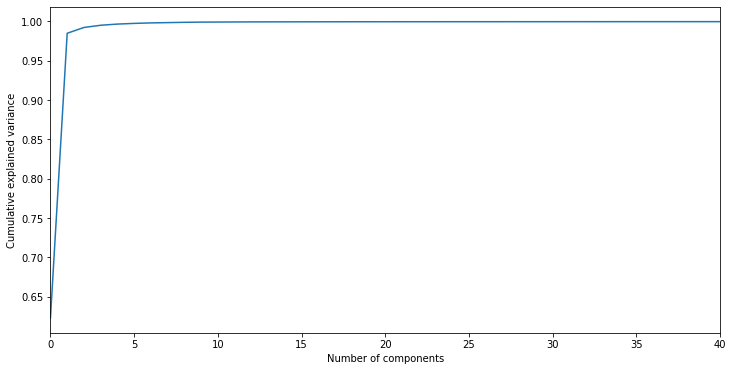

In [8]:
ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xlim([0,40])
plt.savefig('../output/PCA_var_explained.pdf')

plt.show()

## 2. Rebalanced, removing Other, normalize

In [9]:
## Lets normalize and center the data
X_std = X - X.mean(axis=1).reshape(-1,1)
X_std = X_std/X_std.std(axis=1).reshape(-1,1)

## Lets leave out 34
X_std = X_std[Y != 34, :]
Y_std = Y[Y!=34]

X_train, X_test, y_train, y_test = train_test_split(X_std, Y_std, test_size=0.2, random_state=2)


In [10]:
def rebalance_data(X_ub, Y_ub, up_balance_scale=3.):
    # Get classes and counts
    vals, counts = np.unique(Y_ub, return_counts=True)
    # See how bad the inbalance is and choose n_choose according to up_balance_scale
    if counts.max()/counts.min() >up_balance_scale:
        n_choose = int(counts.min()*up_balance_scale)
    else:
        n_choose = int(counts.max())

    X_new = np.zeros((n_choose*vals.shape[0], X_ub.shape[1]))
    Y_new = np.zeros(n_choose*vals.shape[0])
    for i, val in enumerate(vals):
        bool_arr = (Y_ub == val)
        if n_choose-bool_arr.sum()<0:
            random_idxs = np.random.randint(counts[i], size=(n_choose))
            X_new[i*n_choose:(i+1)*n_choose,:] = X_ub[bool_arr, :][random_idxs,:]
        else:
            random_idxs = np.random.randint(counts[i], size=(n_choose-bool_arr.sum()))
            X_new[i*n_choose:(i+1)*n_choose,:] = np.concatenate((X_ub[bool_arr, :],X_ub[bool_arr, :][random_idxs,:]),
                                                                axis=0)
        Y_new[i*n_choose:(i+1)*n_choose] = val
    return X_new, Y_new
X_train, y_train = rebalance_data(X_train, y_train)


## 3. Running new models

LogReg LogisticRegression(max_iter=10000.0) ==========
LogReg
                       precision    recall  f1-score   support

       Acer rubrum L.       0.60      0.54      0.57       930
Pinus palustris Mill.       0.97      0.88      0.92      1746
      Quercus alba L.       0.66      0.63      0.65       890
     Quercus coccinea       0.34      0.65      0.45       398
Quercus laevis Walter       0.63      0.88      0.73       395
     Quercus rubra L.       0.68      0.56      0.62      1258

             accuracy                           0.70      5617
            macro avg       0.65      0.69      0.66      5617
         weighted avg       0.73      0.70      0.70      5617

[[ 506    1  100  165    0  158]
 [   0 1541    0    0  205    0]
 [ 123    0  561   85    0  121]
 [  64    0   29  259    0   46]
 [   0   49    0    0  346    0]
 [ 154    0  154  247    0  703]]


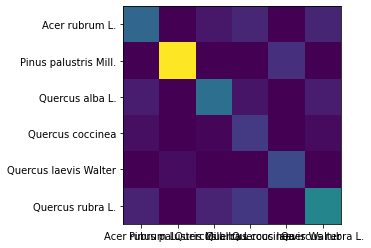

RF RandomForestClassifier(n_jobs=4) ==========
RF
                       precision    recall  f1-score   support

       Acer rubrum L.       0.53      0.52      0.52       930
Pinus palustris Mill.       0.94      0.94      0.94      1746
      Quercus alba L.       0.62      0.56      0.59       890
     Quercus coccinea       0.55      0.39      0.46       398
Quercus laevis Walter       0.76      0.79      0.77       395
     Quercus rubra L.       0.62      0.71      0.66      1258

             accuracy                           0.71      5617
            macro avg       0.67      0.65      0.66      5617
         weighted avg       0.71      0.71      0.71      5617

[[ 485    3  127   77    0  238]
 [   6 1640    2    0   97    1]
 [ 146    3  497   23    0  221]
 [  87    6   50  155    0  100]
 [   0   84    0    0  311    0]
 [ 198   12  125   25    0  898]]


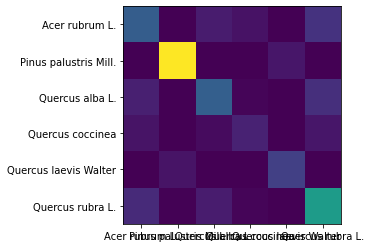

XGB XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None) ==========


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:42:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:02:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:01:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ozaltun/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
                       precision    recall  f1-score   support

       Acer rubrum L.       0.55      0.53      0.54       930
Pinus palustris Mill.       0.97      0.93      0.95      1746
      Quercus alba L.       0.63      0.60      0.62       890
     Quercus coccinea       0.52      0.51      0.51       398
Quercus laevis Walter       0.75      0.87      0.81       395
     Quercus rubra L.       0.67      0.71      0.69      1258

             accuracy                           0.73      5617
            macro avg       0.68      0.69      0.69      5617
         weighted avg       0.73      0.73      0.73      5617

[[ 494    2  127  102    0  205]
 [   1 1632    1    0  112    0]
 [ 139    0  537   35    0  179]
 [  89    0

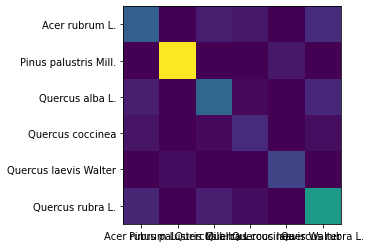

KNN KNeighborsClassifier(n_jobs=4) ==========
KNN
                       precision    recall  f1-score   support

       Acer rubrum L.       0.50      0.52      0.51       930
Pinus palustris Mill.       0.95      0.79      0.86      1746
      Quercus alba L.       0.59      0.59      0.59       890
     Quercus coccinea       0.35      0.59      0.44       398
Quercus laevis Walter       0.48      0.85      0.61       395
     Quercus rubra L.       0.68      0.51      0.59      1258

             accuracy                           0.64      5617
            macro avg       0.59      0.64      0.60      5617
         weighted avg       0.68      0.64      0.65      5617

[[ 482    1  129  172    1  145]
 [   4 1375    0    3  364    0]
 [ 159    0  523   82    0  126]
 [  84    2   45  234    1   32]
 [   0   59    0    0  335    1]
 [ 240    3  194  172    2  647]]


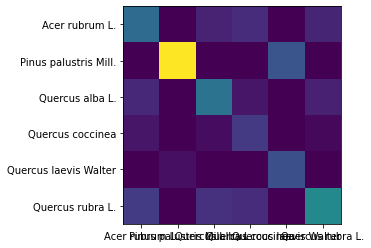

SVM SVC(C=1, decision_function_shape='ovo', kernel='linear') ==========
SVM
                       precision    recall  f1-score   support

       Acer rubrum L.       0.61      0.55      0.58       930
Pinus palustris Mill.       0.97      0.88      0.92      1746
      Quercus alba L.       0.70      0.62      0.65       890
     Quercus coccinea       0.34      0.68      0.45       398
Quercus laevis Walter       0.63      0.86      0.73       395
     Quercus rubra L.       0.70      0.58      0.63      1258

             accuracy                           0.70      5617
            macro avg       0.66      0.70      0.66      5617
         weighted avg       0.74      0.70      0.71      5617

[[ 512    1   92  164    0  161]
 [   1 1541    0    0  204    0]
 [ 121    0  548  108    0  113]
 [  56    0   31  272    0   39]
 [   0   54    0    0  341    0]
 [ 152    0  114  265    0  727]]


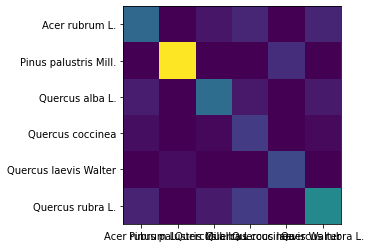

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

'''
Lightweight script to test many models and find winners
:param X_train: training split
:param y_train: training target vector
:param X_test: test split
:param y_test: test target vector
:return: DataFrame of predictions
'''

dfs = []
models = [('LogReg', LogisticRegression(max_iter=1e4)), 
          ('RF', RandomForestClassifier(n_jobs=4)),
          ('XGB', XGBClassifier()),
          ('KNN', KNeighborsClassifier(n_jobs=4)),
          ('SVM', SVC(kernel='linear', C=1, decision_function_shape='ovo'))
        ]
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
target_names = sci_names
for name, model in models:
    print(name, model, "="*10)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred))
    pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names, output_dict=True)).transpose().to_csv('../output/classification_report_{}.csv'.format(name))
    np.save('../output/confusion_matrix_{}.npy'.format(name), confusion_matrix(y_test, y_pred))

    plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest')
    plt.xticks([i for i in range(len(target_names))], target_names)
    plt.yticks([i for i in range(len(target_names))], target_names)
    plt.show()
    
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

In [16]:
final = pd.concat(dfs, ignore_index=True)
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,model
0,82.396265,0.029138,0.705745,0.708072,0.705745,0.705168,LogReg
1,78.367996,0.029978,0.717402,0.716894,0.717402,0.716714,LogReg
2,88.982250,0.039203,0.703414,0.704479,0.703414,0.702739,LogReg
3,80.803030,0.027179,0.703247,0.704003,0.703247,0.702847,LogReg
4,82.882544,0.027797,0.711026,0.711490,0.711026,0.710410,LogReg
5,12.238061,0.170518,0.812157,0.810784,0.812157,0.810866,RF
6,11.318009,0.129478,0.818485,0.817136,0.818485,0.817740,RF
7,11.350333,0.115017,0.812823,0.812461,0.812823,0.812202,RF
8,11.409715,0.129143,0.815820,0.814399,0.815820,0.814787,RF
9,11.378823,0.118192,0.812958,0.812024,0.812958,0.812314,RF


In [17]:
final.to_csv("../output/model_runs_BO.csv")

In [19]:
cv_results

{'fit_time': array([98.60721016, 95.50671411, 91.92302942, 92.8292675 , 94.18748379]),
 'score_time': array([23.03881216, 22.38993311, 22.18219018, 22.19167137, 22.15200639]),
 'test_accuracy': array([0.72189647, 0.71904842, 0.71452505, 0.71251466, 0.71347185]),
 'test_precision_weighted': array([0.72329681, 0.72166124, 0.71837132, 0.71575236, 0.71637033]),
 'test_recall_weighted': array([0.72189647, 0.71904842, 0.71452505, 0.71251466, 0.71347185]),
 'test_f1_weighted': array([0.72154857, 0.71842221, 0.71364389, 0.71231903, 0.71271978])}

,precision,recall,f1-score,support
Acer rubrum L.,0.597403,0.544086,0.569499,930.000000
Pinus palustris Mill.,0.968573,0.882589,0.923584,1746.000000
Quercus alba L.,0.664692,0.630337,0.647059,890.000000
Quercus coccinea,0.342593,0.650754,0.448873,398.000000
Quercus laevis Walter,0.627949,0.875949,0.731501,395.000000
Quercus rubra L.,0.683852,0.558824,0.615048,1258.000000
accuracy,0.697169,0.697169,0.697169,0.697169
macro avg,0.647510,0.690423,0.655927,5617.000000
weighted avg,0.726895,0.697169,0.704899,5617.000000


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)

df = pandas.DataFrame(report).transpose()